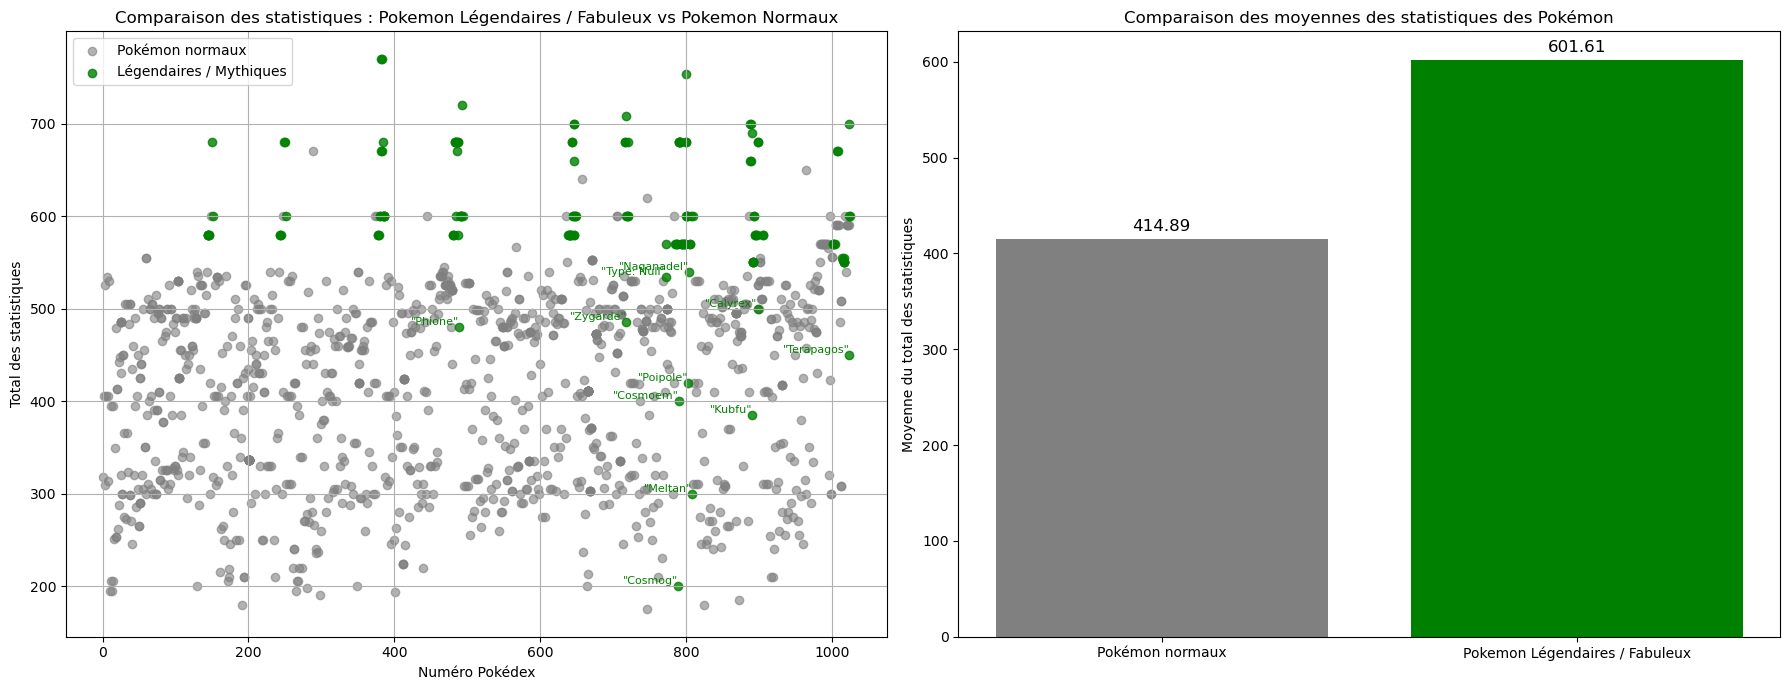

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde


# Charger les données
file_path = 'Dataset/PokemonDatabase.csv'
df = pd.read_csv(file_path)

# Nettoyage
df = df[~df["Alternate Form Name"].astype(str).str.contains("Mega|Gigantamax|Eternamax", na=False)]
df.loc[df["Pokemon Name"].str.startswith('"Unown'), "Pokemon Name"] = '"Unown"'

# Nettoyage des valeurs de "Legendary Type"
df["Legendary Type"] = df["Legendary Type"].astype(str).str.replace('"', '').str.strip()

# Définition des Pokemon Légendaires / Fabuleux et Pokemon normaux
legendary_types = ["Legendary", "Mythical", "Sub-Legendary"]
df_legendary_pokemon = df["Legendary Type"].isin(legendary_types)

# Création du scatter plot
fig, ax = plt.subplots(1, 2, figsize=(18, 7))

# Affichage des Pokémon normaux (gris)
ax[0].scatter(df.loc[~df_legendary_pokemon, "Pokedex Number"],
              df.loc[~df_legendary_pokemon, "Base Stat Total"],
              color="gray", label="Pokémon normaux", alpha=0.6)

# Affichage des Pokémon Pokemon Légendaires / Fabuleux (verts)
ax[0].scatter(df.loc[df_legendary_pokemon, "Pokedex Number"],
              df.loc[df_legendary_pokemon, "Base Stat Total"],
              color="green", label="Légendaires / Mythiques", alpha=0.8)

# Affichage des noms des Pokémon dont le "Base Stat Total" est inférieur à 550
for _, row in df[(df["Base Stat Total"] < 550) & df_legendary_pokemon].iterrows():
    ax[0].text(row["Pokedex Number"], row["Base Stat Total"], row["Pokemon Name"],
               fontsize=8, ha='right', va='bottom', color='green')

# Titres et légendes pour le scatter plot
ax[0].set_xlabel("Numéro Pokédex")
ax[0].set_ylabel("Total des statistiques")
ax[0].set_title("Comparaison des statistiques : Pokemon Légendaires / Fabuleux vs Pokemon Normaux")
ax[0].legend()
ax[0].grid(True)

# Calcul des moyennes des stats des Pokémon Pokemon Légendaires / Fabuleux et normaux
mean_legendary = df[df_legendary_pokemon]["Base Stat Total"].mean()
mean_normal = df[~df_legendary_pokemon]["Base Stat Total"].mean()

# Création de l'histogramme des moyennes
bars = ax[1].bar(["Pokémon normaux", "Pokemon Légendaires / Fabuleux"], [mean_normal, mean_legendary], color=['gray', 'green'])

# Affichage des valeurs sur l'histogramme
for bar in bars:
    yval = bar.get_height()
    ax[1].text(bar.get_x() + bar.get_width() / 2, yval + 5, round(yval, 2), ha='center', va='bottom', fontsize=12)

# Ajout des titres et légendes pour l'histogramme
ax[1].set_ylabel("Moyenne du total des statistiques")
ax[1].set_title("Comparaison des moyennes des statistiques des Pokémon")

# Affichage du graphique
plt.tight_layout()
plt.show()


Nombre de Pokémon par couleur :
Color
blue    558
red     404
grey    188
Name: count, dtype: int64


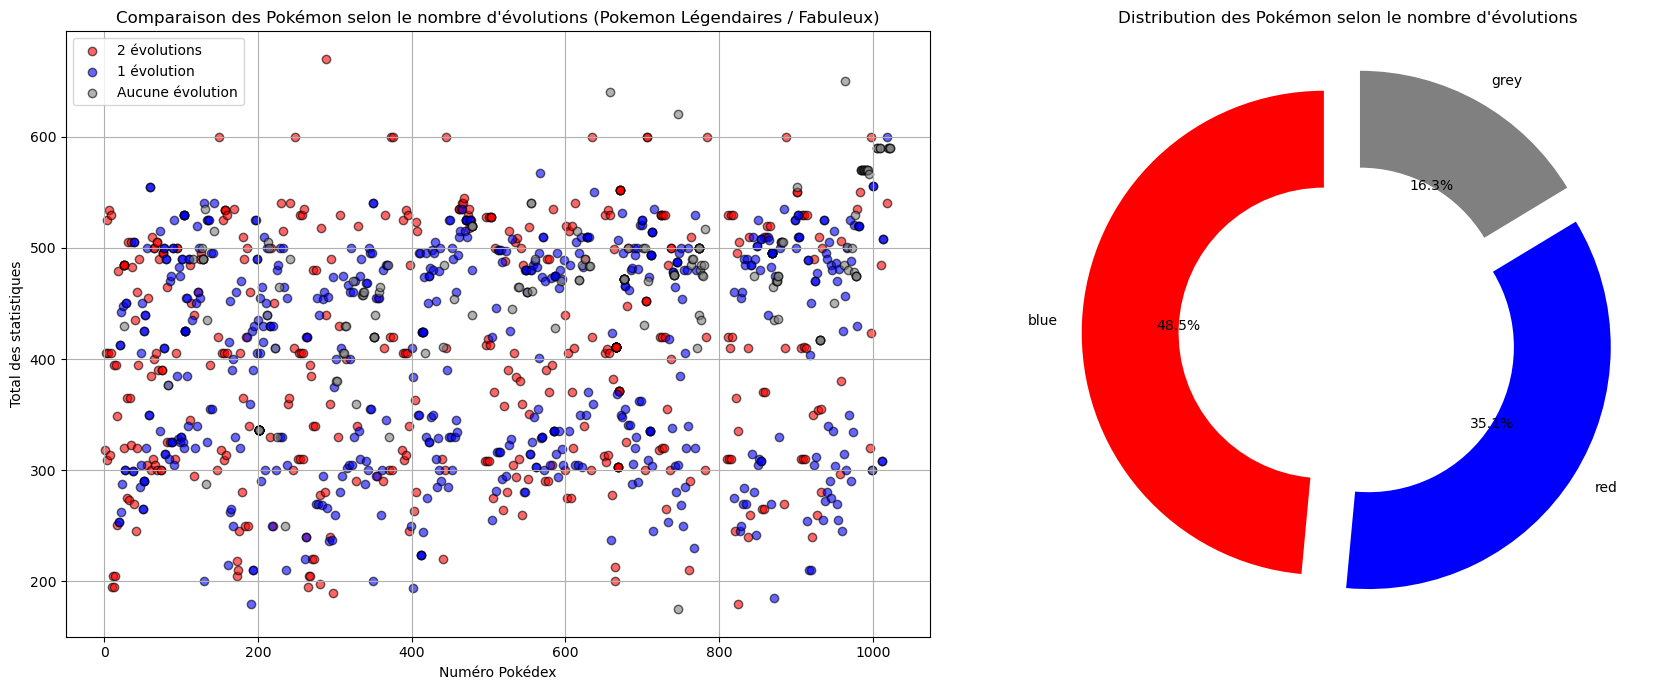

In [8]:
# Exclure les Pokémon Pokemon Légendaires / Fabuleux
df_base_pokemon = df[~df_legendary_pokemon].copy()  # Création d'une copie


# Créer un dictionnaire pour mapper les IDs d'évolution
pokemon_id_dict = dict(zip(df_base_pokemon["Pokemon Id"], df_base_pokemon["Pokemon Name"]))

# Fonction pour trouver la chaîne d'évolution à partir d'un Pokémon donné
def get_evolution_chain(pokemon_id, df):
    chain = [pokemon_id]
    current_pokemon = df_base_pokemon[df_base_pokemon["Pokemon Id"] == pokemon_id]

    # Remonter la chaîne d'évolution en suivant les pré-évolutions
    while not current_pokemon["Pre-Evolution Pokemon Id"].isnull().values[0]:
        pre_evolution_id = current_pokemon["Pre-Evolution Pokemon Id"].values[0]
        chain.append(pre_evolution_id)
        current_pokemon = df_base_pokemon[df_base_pokemon["Pokemon Id"] == pre_evolution_id]

    return chain

# Créer une colonne pour stocker la couleur des points
df_base_pokemon['Color'] = 'grey'  # Initialisation avec 'grey' (aucune évolution)

# Mettre à jour la couleur pour les Pokémon selon la chaîne d'évolutions
for _, row in df_base_pokemon.iterrows():
    chain = get_evolution_chain(row["Pokemon Id"], df_base_pokemon)
    # Si la chaîne contient 3 Pokémon (2 évolutions), colorier en rouge
    if len(chain) == 3:
        df_base_pokemon.loc[df_base_pokemon["Pokemon Id"].isin(chain), 'Color'] = 'red'
    # Si la chaîne contient 2 Pokémon (1 évolution), colorier en bleu
    elif len(chain) == 2:
        df_base_pokemon.loc[df_base_pokemon["Pokemon Id"].isin(chain), 'Color'] = 'blue'

# Affichage du nombre de chaque couleur
color_counts = df_base_pokemon['Color'].value_counts()
print("Nombre de Pokémon par couleur :")
print(color_counts)

# Création du graphique
fig, ax = plt.subplots(1, 2, figsize=(18, 7))

# Première partie : Nuage de points
# Affichage des Pokémon avec la couleur de la chaîne d'évolution
scatter_red = ax[0].scatter(df_base_pokemon.loc[df_base_pokemon['Color'] == 'red', "Pokedex Number"],
                            df_base_pokemon.loc[df_base_pokemon['Color'] == 'red', "Base Stat Total"],
                            color='red', label='2 évolutions', alpha=0.6, edgecolors='black')

scatter_blue = ax[0].scatter(df_base_pokemon.loc[df_base_pokemon['Color'] == 'blue', "Pokedex Number"],
                             df_base_pokemon.loc[df_base_pokemon['Color'] == 'blue', "Base Stat Total"],
                             color='blue', label='1 évolution', alpha=0.6, edgecolors='black')

scatter_grey = ax[0].scatter(df_base_pokemon.loc[df_base_pokemon['Color'] == 'grey', "Pokedex Number"],
                              df_base_pokemon.loc[df_base_pokemon['Color'] == 'grey', "Base Stat Total"],
                              color='grey', label='Aucune évolution', alpha=0.6, edgecolors='black')

# Titres et légendes
ax[0].set_xlabel("Numéro Pokédex")
ax[0].set_ylabel("Total des statistiques")
ax[0].set_title("Comparaison des Pokémon selon le nombre d'évolutions (Pokemon Légendaires / Fabuleux)")

# Affichage de la légende
ax[0].legend()
ax[0].grid(True)

# Deuxième partie : Donut Chart
# Création du donut chart
labels = color_counts.index
sizes = color_counts.values
explode = (0.1, 0.1, 0.1)  # Séparation des tranches pour l'effet visuel

ax[1].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['red', 'blue', 'grey'], explode=explode, wedgeprops={'width': 0.4})
ax[1].set_title("Distribution des Pokémon selon le nombre d'évolutions")

# Affichage du graphique
plt.tight_layout()
plt.show()


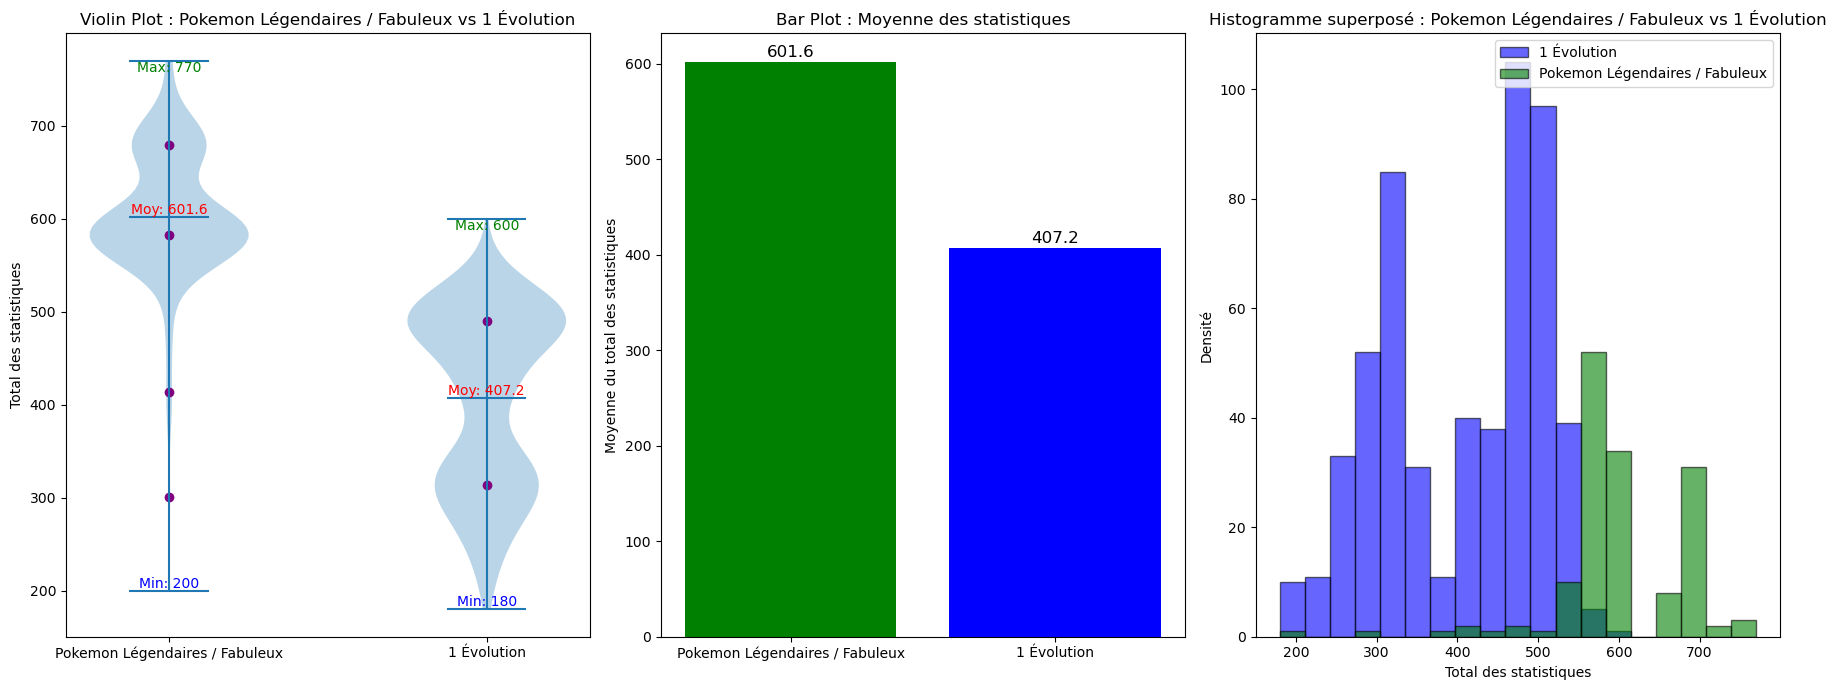

In [9]:
# Filtrer les Pokémon Pokemon Légendaires / Fabuleux et ceux ayant 1 évolution
df_single_evolution = df_base_pokemon[df_base_pokemon['Color'] == 'blue']  # Pokémon avec 1 évolution
df_legendary_pokemon = df[df_legendary_pokemon]  # Assurez-vous que df_legendary_pokemon est déjà filtré

# Extraire les valeurs pour les statistiques de base
stats_single_evolution = df_single_evolution['Base Stat Total'].values
stats_legendary = df_legendary_pokemon['Base Stat Total'].values

# Calcul des statistiques pour affichage
mean_stats = [np.mean(stats_legendary), np.mean(stats_single_evolution)]
min_stats = [np.min(stats_legendary), np.min(stats_single_evolution)]
max_stats = [np.max(stats_legendary), np.max(stats_single_evolution)]

# Fonction pour trouver les pics (modes)
def find_peaks(data):
    kde = gaussian_kde(data)  # Densité de probabilité
    x_vals = np.linspace(min(data), max(data), 1000)
    y_vals = kde(x_vals)

    peak_indices = np.where((y_vals[1:-1] > y_vals[:-2]) & (y_vals[1:-1] > y_vals[2:]))[0] + 1
    peaks = x_vals[peak_indices]

    return peaks

peaks_legendary = find_peaks(stats_legendary)
peaks_single_evolution = find_peaks(stats_single_evolution)

# Création du graphique
fig, ax = plt.subplots(1, 3, figsize=(18, 7))

# 1. Violin Plot avec stats et pics
parts = ax[0].violinplot([stats_legendary, stats_single_evolution], showmeans=True, showextrema=True)

# Ajouter les valeurs min, max et moyennes
for i, (mean, min_val, max_val, peaks) in enumerate(zip(mean_stats, min_stats, max_stats, [peaks_legendary, peaks_single_evolution]), start=1):
    ax[0].text(i, mean, f'Moy: {mean:.1f}', ha='center', va='bottom', fontsize=10, color='red')
    ax[0].text(i, min_val, f'Min: {min_val}', ha='center', va='bottom', fontsize=10, color='blue')
    ax[0].text(i, max_val, f'Max: {max_val}', ha='center', va='top', fontsize=10, color='green')

    # Ajouter les pics (modes)
    for peak in peaks:
        ax[0].scatter(i, peak, color='purple', marker='o', label='Pic' if i == 1 else "")

ax[0].set_xticks([1, 2])
ax[0].set_xticklabels(["Pokemon Légendaires / Fabuleux", "1 Évolution"])
ax[0].set_title("Violin Plot : Pokemon Légendaires / Fabuleux vs 1 Évolution")
ax[0].set_ylabel("Total des statistiques")

# 2. Bar Plot avec affichage des valeurs précises
bars = ax[1].bar(["Pokemon Légendaires / Fabuleux", "1 Évolution"], mean_stats, color=['green', 'blue'])

# Ajouter les valeurs des moyennes sur les barres
for bar, value in zip(bars, mean_stats):
    ax[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, f'{value:.1f}', ha='center', fontsize=12)

ax[1].set_title("Bar Plot : Moyenne des statistiques")
ax[1].set_ylabel("Moyenne du total des statistiques")

# 3. Histogramme superposé
bins = np.linspace(min(min(stats_single_evolution), min(stats_legendary)),
                   max(max(stats_single_evolution), max(stats_legendary)), 20)

ax[2].hist(stats_single_evolution, bins=bins, color='blue', alpha=0.6, label="1 Évolution", edgecolor='black')
ax[2].hist(stats_legendary, bins=bins, color='green', alpha=0.6, label="Pokemon Légendaires / Fabuleux", edgecolor='black')

ax[2].set_title("Histogramme superposé : Pokemon Légendaires / Fabuleux vs 1 Évolution")
ax[2].set_xlabel("Total des statistiques")
ax[2].set_ylabel("Densité")
ax[2].legend()

# Affichage du graphique
plt.tight_layout()
plt.show()


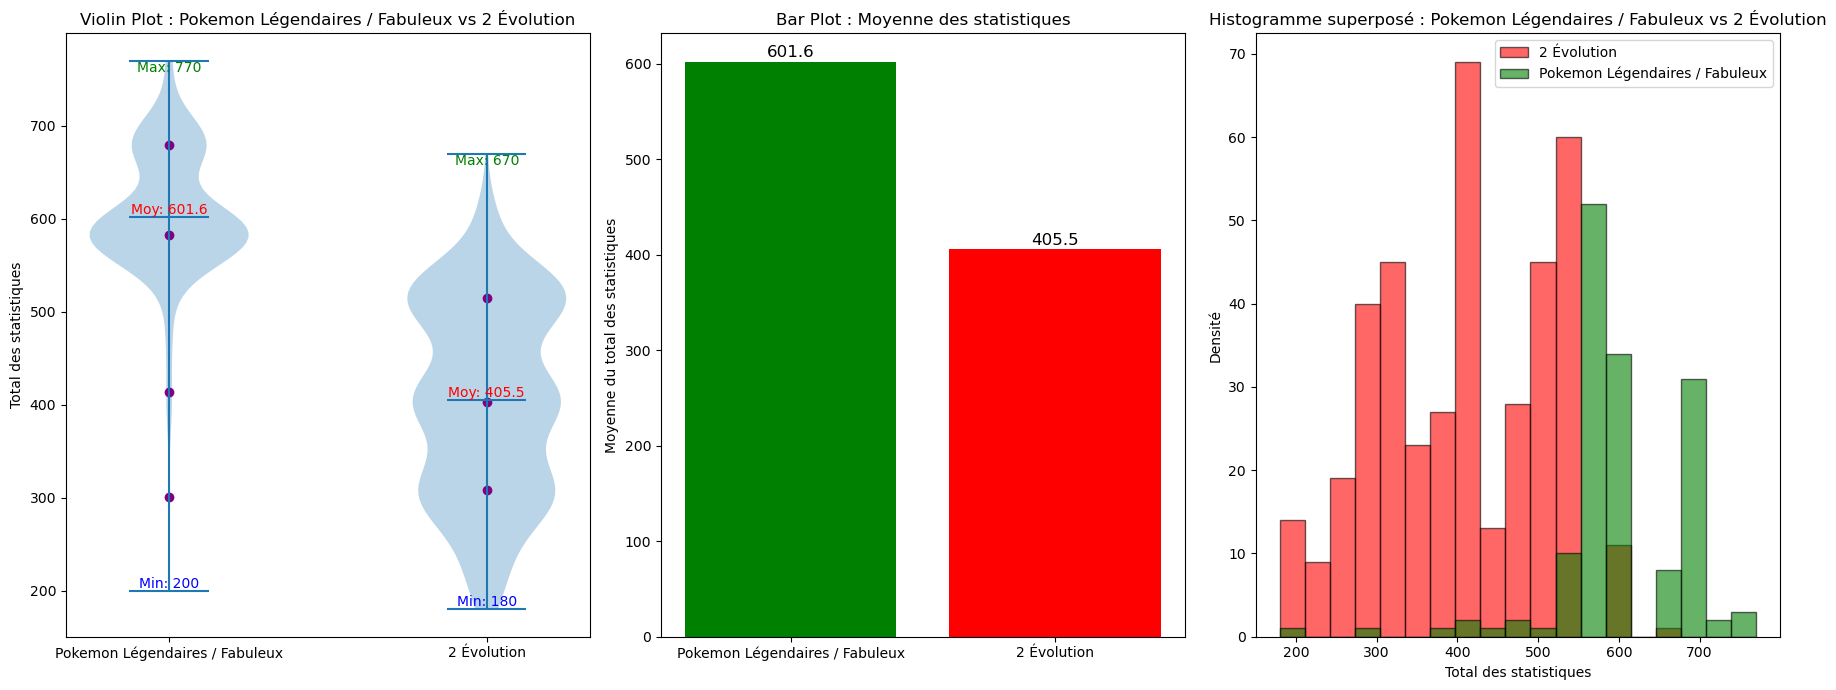

In [10]:

# Filtrer les Pokémon Pokemon Légendaires / Fabuleux et ceux ayant 1 évolution
df_two_evolution = df_base_pokemon[df_base_pokemon['Color'] == 'red']  # Pokémon avec 1 évolution

# Extraire les valeurs pour les statistiques de base
stats_two_evolution = df_two_evolution['Base Stat Total'].values
stats_legendary = df_legendary_pokemon['Base Stat Total'].values

# Calcul des statistiques pour affichage
mean_stats = [np.mean(stats_legendary), np.mean(stats_two_evolution)]
min_stats = [np.min(stats_legendary), np.min(stats_two_evolution)]
max_stats = [np.max(stats_legendary), np.max(stats_two_evolution)]


# Fonction pour trouver les pics (modes)
def find_peaks(data):
    kde = gaussian_kde(data)  # Densité de probabilité
    x_vals = np.linspace(min(data), max(data), 1000)
    y_vals = kde(x_vals)

    peak_indices = np.where((y_vals[1:-1] > y_vals[:-2]) & (y_vals[1:-1] > y_vals[2:]))[0] + 1
    peaks = x_vals[peak_indices]

    return peaks


peaks_legendary = find_peaks(stats_legendary)
peaks_two_evolution = find_peaks(stats_two_evolution)

# Création du graphique
fig, ax = plt.subplots(1, 3, figsize=(18, 7))

# 1. Violin Plot avec stats et pics
parts = ax[0].violinplot([stats_legendary, stats_two_evolution], showmeans=True, showextrema=True)

# Ajouter les valeurs min, max et moyennes
for i, (mean, min_val, max_val, peaks) in enumerate(
        zip(mean_stats, min_stats, max_stats, [peaks_legendary, peaks_two_evolution]), start=1):
    ax[0].text(i, mean, f'Moy: {mean:.1f}', ha='center', va='bottom', fontsize=10, color='red')
    ax[0].text(i, min_val, f'Min: {min_val}', ha='center', va='bottom', fontsize=10, color='blue')
    ax[0].text(i, max_val, f'Max: {max_val}', ha='center', va='top', fontsize=10, color='green')

    # Ajouter les pics (modes)
    for peak in peaks:
        ax[0].scatter(i, peak, color='purple', marker='o', label='Pic' if i == 1 else "")

ax[0].set_xticks([1, 2])
ax[0].set_xticklabels(["Pokemon Légendaires / Fabuleux", "2 Évolution"])
ax[0].set_title("Violin Plot : Pokemon Légendaires / Fabuleux vs 2 Évolution")
ax[0].set_ylabel("Total des statistiques")

# 2. Bar Plot avec affichage des valeurs précises
bars = ax[1].bar(["Pokemon Légendaires / Fabuleux", "2 Évolution"], mean_stats, color=['green', 'red'])

# Ajouter les valeurs des moyennes sur les barres
for bar, value in zip(bars, mean_stats):
    ax[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, f'{value:.1f}', ha='center', fontsize=12)

ax[1].set_title("Bar Plot : Moyenne des statistiques")
ax[1].set_ylabel("Moyenne du total des statistiques")

# 3. Histogramme superposé
bins = np.linspace(min(min(stats_two_evolution), min(stats_legendary)),
                   max(max(stats_two_evolution), max(stats_legendary)), 20)

ax[2].hist(stats_two_evolution, bins=bins, color='red', alpha=0.6, label="2 Évolution", edgecolor='black')
ax[2].hist(stats_legendary, bins=bins, color='green', alpha=0.6, label="Pokemon Légendaires / Fabuleux", edgecolor='black')

ax[2].set_title("Histogramme superposé : Pokemon Légendaires / Fabuleux vs 2 Évolution")
ax[2].set_xlabel("Total des statistiques")
ax[2].set_ylabel("Densité")
ax[2].legend()

# Affichage du graphique
plt.tight_layout()
plt.show()

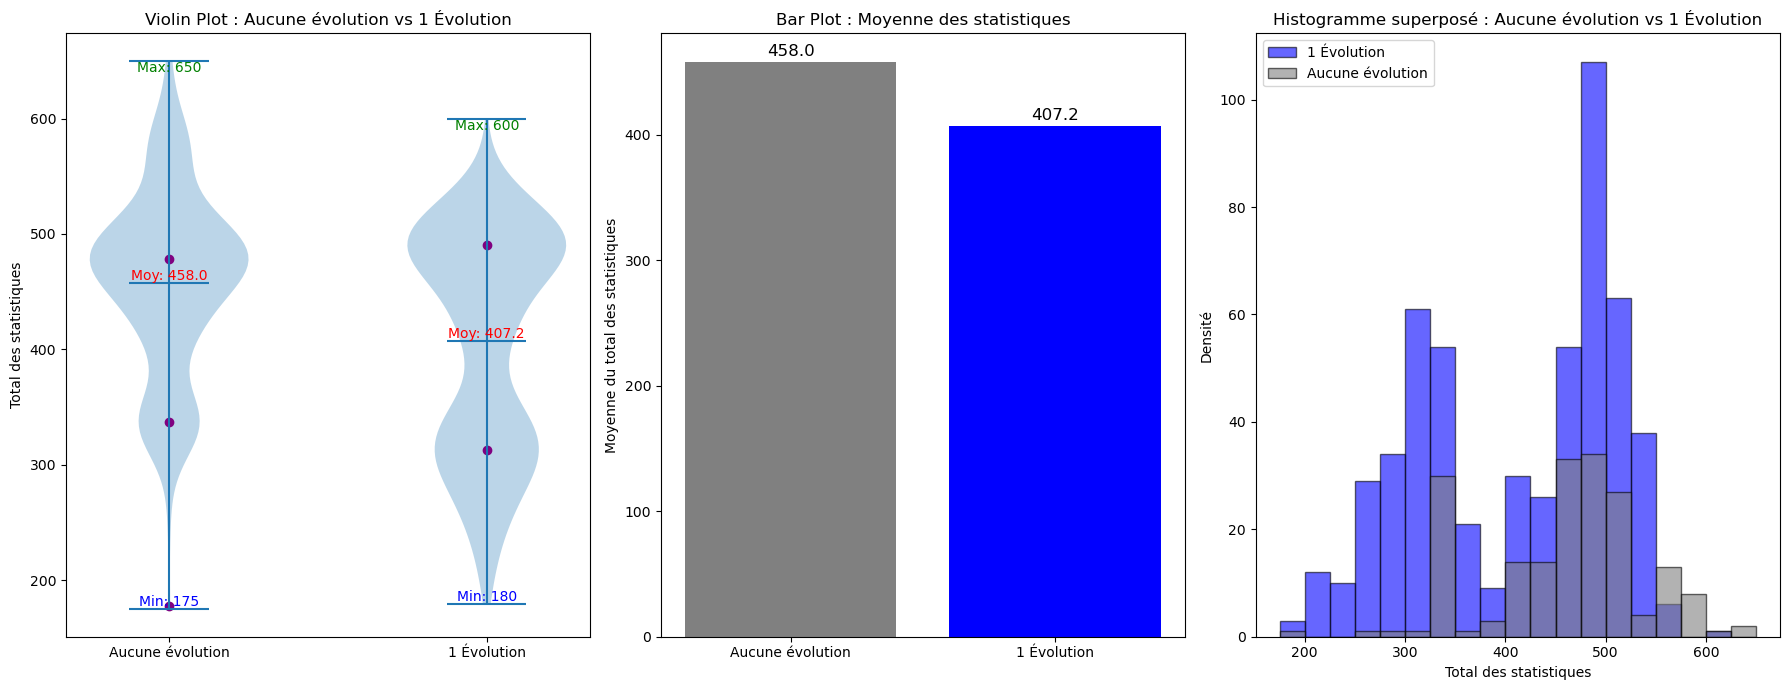

In [11]:
# Filtrer les Pokémon avec Aucune évolution et ceux ayant 1 évolution
df_none_evolution = df_base_pokemon[df_base_pokemon['Color'] == 'grey']

# Extraire les valeurs pour les statistiques de base
stats_none_evolution = df_none_evolution['Base Stat Total'].values

# Calcul des statistiques pour affichage
mean_stats = [np.mean(stats_none_evolution), np.mean(stats_single_evolution)]
min_stats = [np.min(stats_none_evolution), np.min(stats_single_evolution)]
max_stats = [np.max(stats_none_evolution), np.max(stats_single_evolution)]

# Fonction pour trouver les pics (modes)
def find_peaks(data):
    kde = gaussian_kde(data)  # Densité de probabilité
    x_vals = np.linspace(min(data), max(data), 1000)
    y_vals = kde(x_vals)

    peak_indices = np.where((y_vals[1:-1] > y_vals[:-2]) & (y_vals[1:-1] > y_vals[2:]))[0] + 1
    peaks = x_vals[peak_indices]

    return peaks

peaks_none_evolution = find_peaks(stats_none_evolution)

# Création du graphique
fig, ax = plt.subplots(1, 3, figsize=(18, 7))

# 1. Violin Plot avec stats et pics
parts = ax[0].violinplot([stats_none_evolution, stats_single_evolution], showmeans=True, showextrema=True)

# Ajouter les valeurs min, max et moyennes
for i, (mean, min_val, max_val, peaks) in enumerate(zip(mean_stats, min_stats, max_stats, [peaks_none_evolution, peaks_single_evolution]), start=1):
    ax[0].text(i, mean, f'Moy: {mean:.1f}', ha='center', va='bottom', fontsize=10, color='red')
    ax[0].text(i, min_val, f'Min: {min_val}', ha='center', va='bottom', fontsize=10, color='blue')
    ax[0].text(i, max_val, f'Max: {max_val}', ha='center', va='top', fontsize=10, color='green')

    # Ajouter les pics (modes)
    for peak in peaks:
        ax[0].scatter(i, peak, color='purple', marker='o', label='Pic' if i == 1 else "")

ax[0].set_xticks([1, 2])
ax[0].set_xticklabels(["Aucune évolution", "1 Évolution"])
ax[0].set_title("Violin Plot : Aucune évolution vs 1 Évolution")
ax[0].set_ylabel("Total des statistiques")

# 2. Bar Plot avec affichage des valeurs précises
bars = ax[1].bar(["Aucune évolution", "1 Évolution"], mean_stats, color=['grey', 'blue'])

# Ajouter les valeurs des moyennes sur les barres
for bar, value in zip(bars, mean_stats):
    ax[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, f'{value:.1f}', ha='center', fontsize=12)

ax[1].set_title("Bar Plot : Moyenne des statistiques")
ax[1].set_ylabel("Moyenne du total des statistiques")

# 3. Histogramme superposé
bins = np.linspace(min(min(stats_single_evolution), min(stats_none_evolution)),
                   max(max(stats_single_evolution), max(stats_none_evolution)), 20)

ax[2].hist(stats_single_evolution, bins=bins, color='blue', alpha=0.6, label="1 Évolution", edgecolor='black')
ax[2].hist(stats_none_evolution, bins=bins, color='grey', alpha=0.6, label="Aucune évolution", edgecolor='black')

ax[2].set_title("Histogramme superposé : Aucune évolution vs 1 Évolution")
ax[2].set_xlabel("Total des statistiques")
ax[2].set_ylabel("Densité")
ax[2].legend()

# Affichage du graphique
plt.tight_layout()
plt.show()


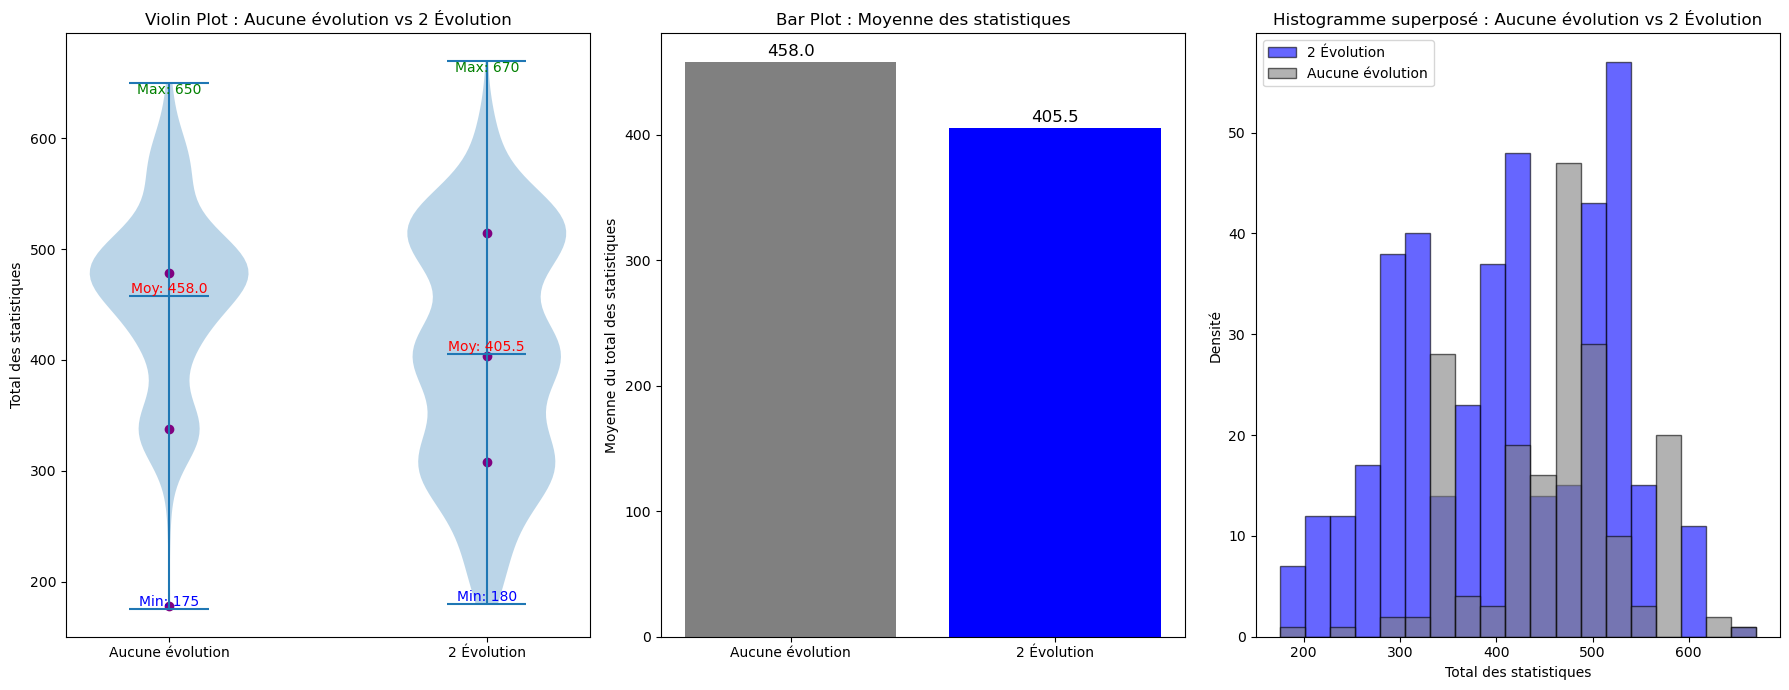

In [12]:

# Calcul des statistiques pour affichage
mean_stats = [np.mean(stats_none_evolution), np.mean(stats_two_evolution)]
min_stats = [np.min(stats_none_evolution), np.min(stats_two_evolution)]
max_stats = [np.max(stats_none_evolution), np.max(stats_two_evolution)]

# Fonction pour trouver les pics (modes)
def find_peaks(data):
    kde = gaussian_kde(data)  # Densité de probabilité
    x_vals = np.linspace(min(data), max(data), 1000)
    y_vals = kde(x_vals)

    peak_indices = np.where((y_vals[1:-1] > y_vals[:-2]) & (y_vals[1:-1] > y_vals[2:]))[0] + 1
    peaks = x_vals[peak_indices]

    return peaks

peaks_none_evolution = find_peaks(stats_none_evolution)

# Création du graphique
fig, ax = plt.subplots(1, 3, figsize=(18, 7))

# 1. Violin Plot avec stats et pics
parts = ax[0].violinplot([stats_none_evolution, stats_two_evolution], showmeans=True, showextrema=True)

# Ajouter les valeurs min, max et moyennes
for i, (mean, min_val, max_val, peaks) in enumerate(zip(mean_stats, min_stats, max_stats, [peaks_none_evolution, peaks_two_evolution]), start=1):
    ax[0].text(i, mean, f'Moy: {mean:.1f}', ha='center', va='bottom', fontsize=10, color='red')
    ax[0].text(i, min_val, f'Min: {min_val}', ha='center', va='bottom', fontsize=10, color='blue')
    ax[0].text(i, max_val, f'Max: {max_val}', ha='center', va='top', fontsize=10, color='green')

    # Ajouter les pics (modes)
    for peak in peaks:
        ax[0].scatter(i, peak, color='purple', marker='o', label='Pic' if i == 1 else "")

ax[0].set_xticks([1, 2])
ax[0].set_xticklabels(["Aucune évolution", "2 Évolution"])
ax[0].set_title("Violin Plot : Aucune évolution vs 2 Évolution")
ax[0].set_ylabel("Total des statistiques")

# 2. Bar Plot avec affichage des valeurs précises
bars = ax[1].bar(["Aucune évolution", "2 Évolution"], mean_stats, color=['grey', 'blue'])

# Ajouter les valeurs des moyennes sur les barres
for bar, value in zip(bars, mean_stats):
    ax[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, f'{value:.1f}', ha='center', fontsize=12)

ax[1].set_title("Bar Plot : Moyenne des statistiques")
ax[1].set_ylabel("Moyenne du total des statistiques")

# 3. Histogramme superposé
bins = np.linspace(min(min(stats_two_evolution), min(stats_none_evolution)),
                   max(max(stats_two_evolution), max(stats_none_evolution)), 20)

ax[2].hist(stats_two_evolution, bins=bins, color='blue', alpha=0.6, label="2 Évolution", edgecolor='black')
ax[2].hist(stats_none_evolution, bins=bins, color='grey', alpha=0.6, label="Aucune évolution", edgecolor='black')

ax[2].set_title("Histogramme superposé : Aucune évolution vs 2 Évolution")
ax[2].set_xlabel("Total des statistiques")
ax[2].set_ylabel("Densité")
ax[2].legend()

# Affichage du graphique
plt.tight_layout()
plt.show()
